In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.chdir("/Users/bytedance/MLTrader-Research/")
import sys
sys.path.insert(0, ".")
import research.orderbook_strategies.utils.helper as helper
import research.orderbook_strategies.utils.factor_analysis as factor_analysis
import research.orderbook_strategies.utils.factors as factors
from research.orderbook_strategies.utils.product_info import product_info
import itertools
import pandas as pd
from collections import OrderedDict
import functools
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import dask
from dask import compute, delayed
warnings.filterwarnings('ignore')
import scipy
from scipy.stats import norm
import seaborn as sns
product_list = ["OPUSDT","BTCUSDT", "ETHUSDT", "APTUSDT", "1000PEPEUSDT"]
ATR_FILTER = 0.02
MAX_SPREAD_RATIO = 1.1

In [4]:
factor = factors.factor_adx_directionalV2()

# %%time
# 构造因子
for product in product_list:
    file_list = helper.get_file_list(product)
    helper.parLapply(file_list, 
                        factor_analysis.build_composite_signal,
                        signal_list=[factor], 
                        product=product,
                        overwrite=False,)

KeyboardInterrupt: 

In [5]:
# 脚本现在开始
factor = factors.factor_adx_directionalV2()
periods = factor.params['period']

signal_name_format = factor.factor_name

In [ ]:
all_product_signal_periods = {}
for period in periods:
    signal_name = signal_name_format.format(period=period)
    all_product_signal_periods[period] = helper.get_signal_data(product_list, signal_name)
    
tick_ret = helper.get_field_data(product_list, "ret")

In [ ]:
# # 需要验证这个是否和pnl成正比
# for period in [64, 128, 512, 1024, 2048, 4096]
#     for product in product_list:
#         T = len(all_product_signal[product])
#         arr = all_product_signal[product]
#         ret = tick_ret[product]
#         ret = pd.Series(ret).rolling(period).sum().shift(-period).values  # period return
#         lower, higher = np.quantile(arr, [0.1, 0.9])
#         mask = (arr <= lower) | (arr >= higher)
#         df = pd.DataFrame({"signal": arr[mask], "ret": ret[mask]})
#         corr = df.corr().iloc[0, 1].item()
#         print(f"{product} corr: {corr: .4%}")
    

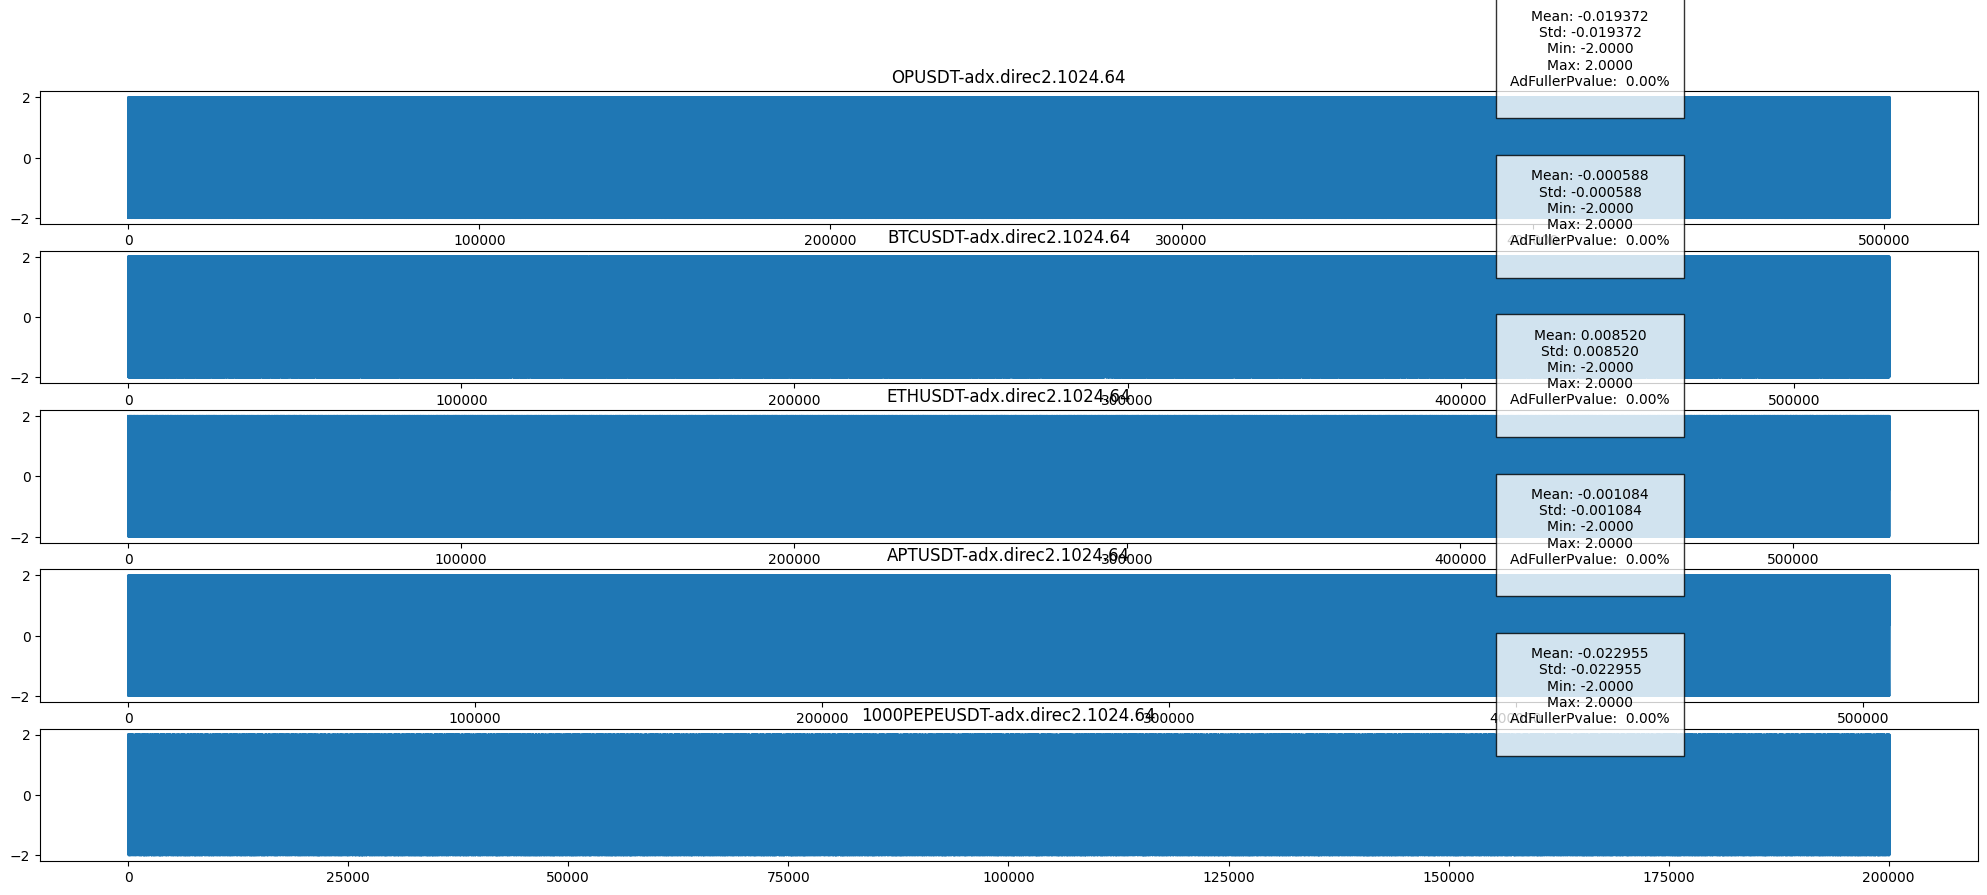

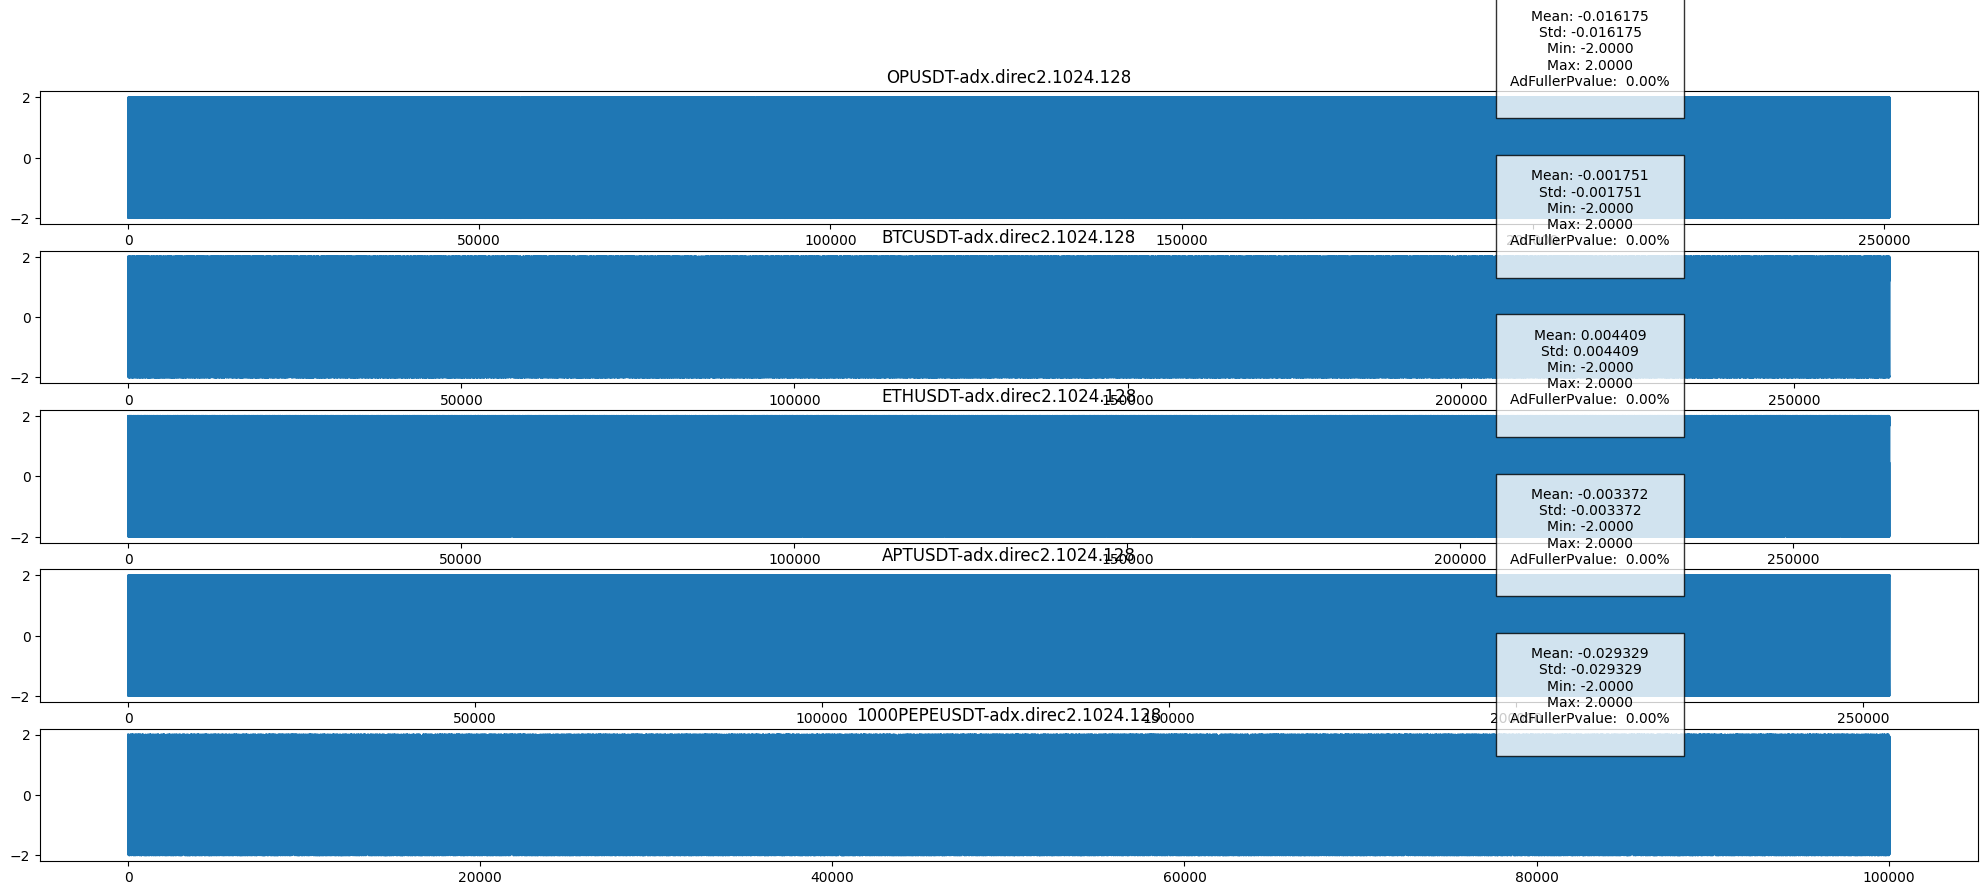

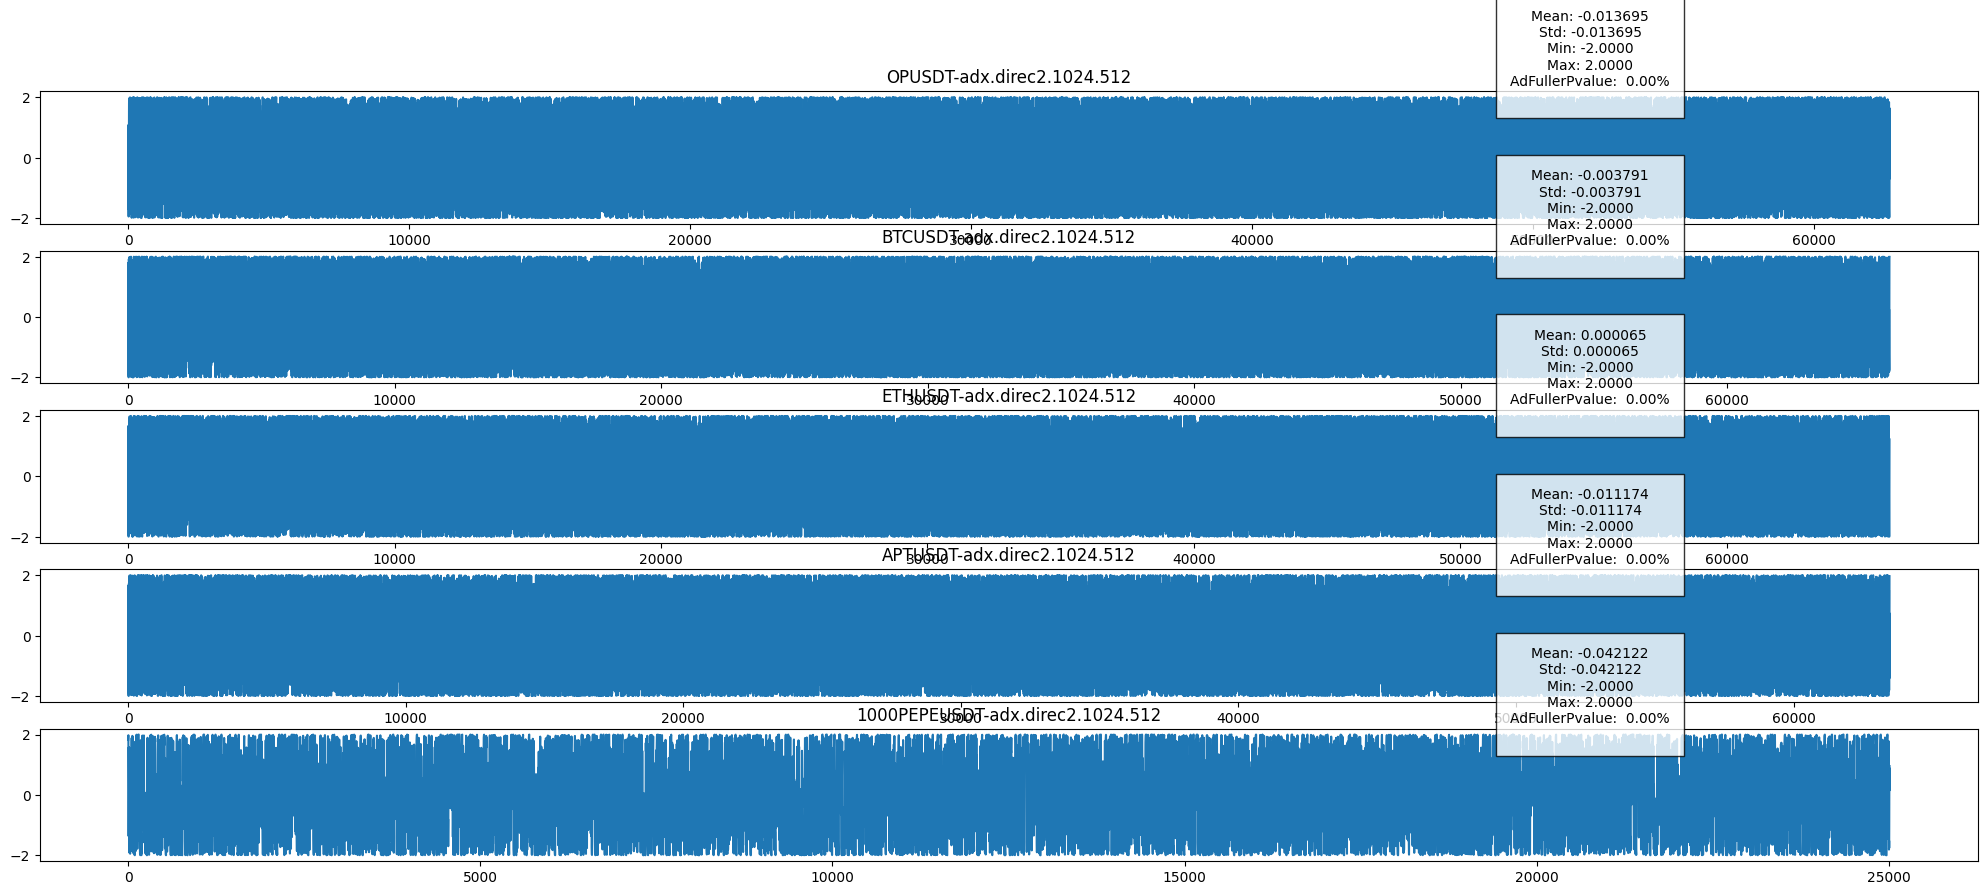

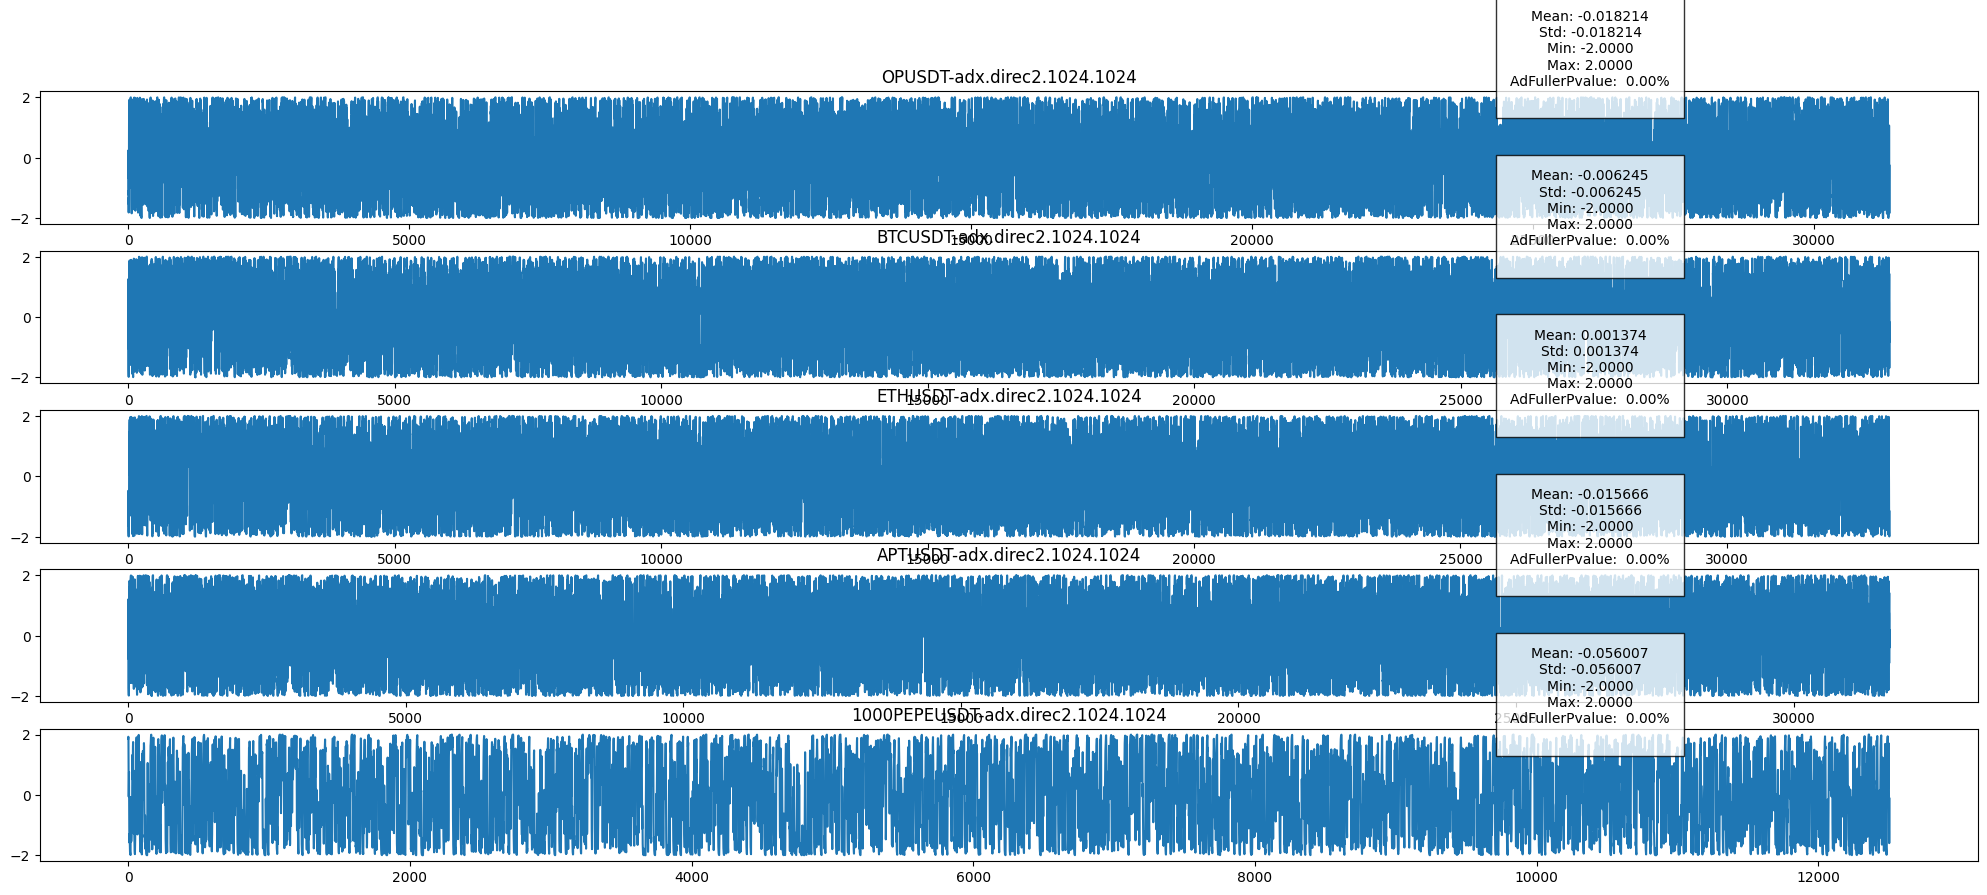

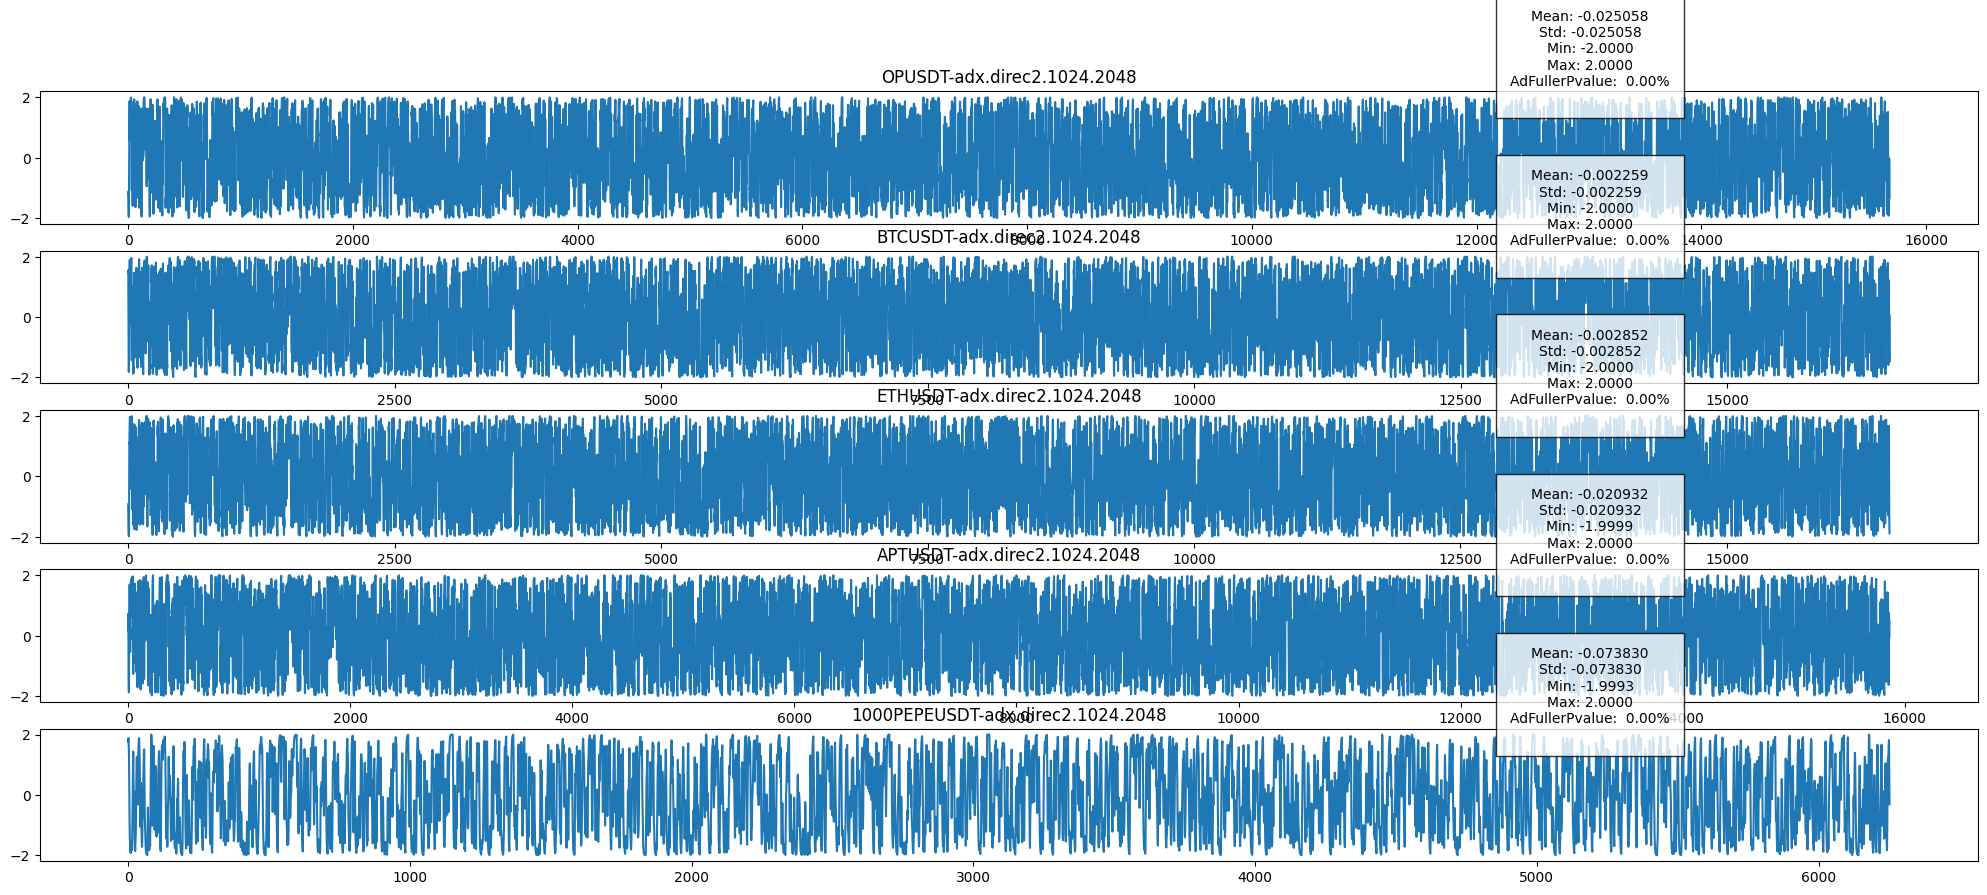

In [ ]:
import statsmodels.tsa.stattools as ts
for period in periods:
    f, axes = plt.subplots(len(product_list), 1, figsize=(5 * len(product_list), 10))
    signal_name = signal_name_format.format(period=period)
    for i, product in enumerate(product_list):
        arr = all_product_signal_periods[period][product]
        
        T = len(arr)

        arr = arr[np.arange(0, T, period)]
        axes[i].plot(arr)
        axes[i].set_title(product + "-" + signal_name)
        _, p_val, _, _, _ = ts.adfuller(arr, maxlag=int(pow(len(arr)-1,(1/3))), regression='ct', autolag=None)
        
        mean = np.nanmean(arr)
        std = np.nanmean(arr)
        min_val = np.nanmin(arr)
        max_val = np.nanmax(arr)
        summary_text = f"Mean: {mean:.6f}\nStd: {std:.6f}\nMin: {min_val:.4f}\nMax: {max_val:.4f}\nAdFullerPvalue: {p_val: .2%}\n"
        axes[i].text(0.8, 0.9, summary_text, transform=axes[i].transAxes, ha='center', va='bottom',
                bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    f.show()

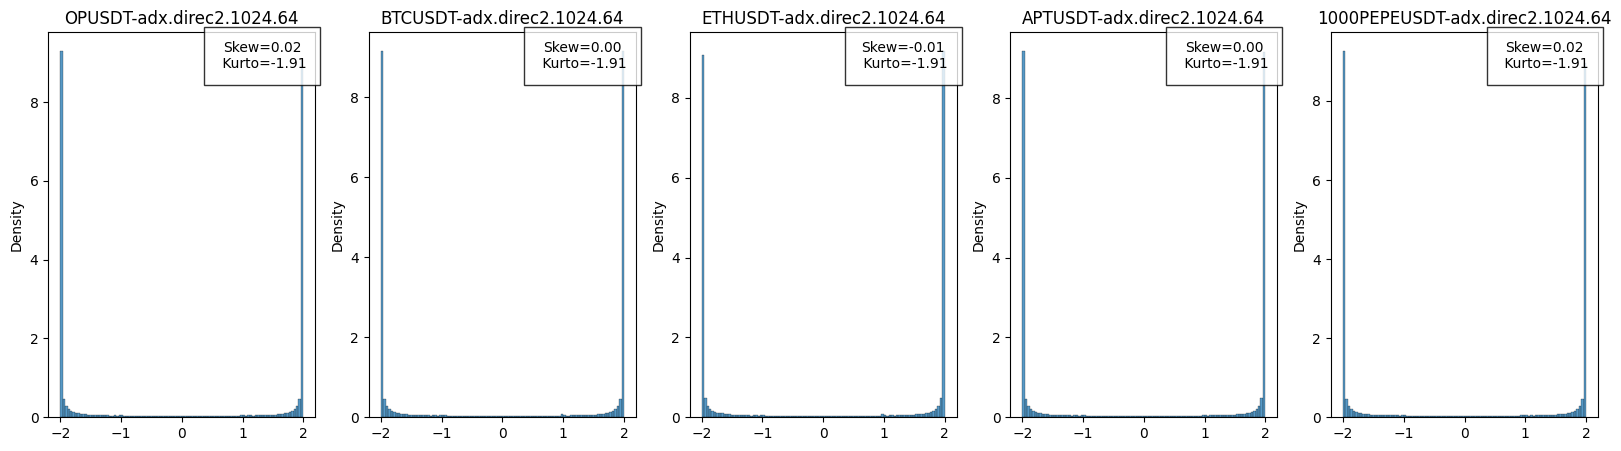

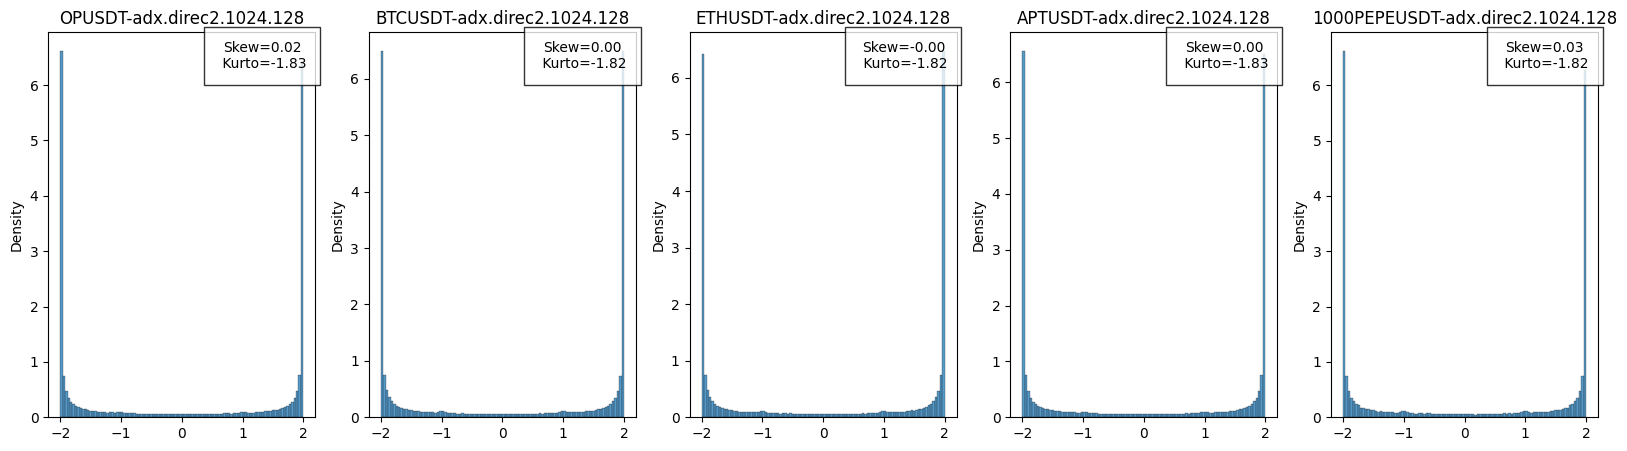

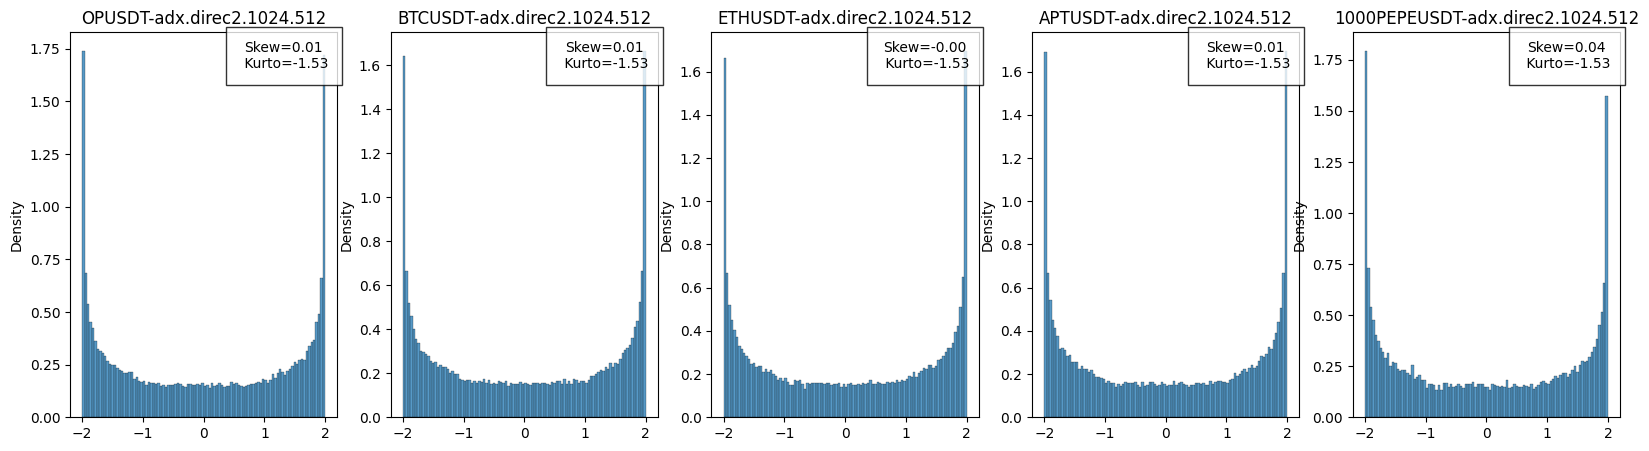

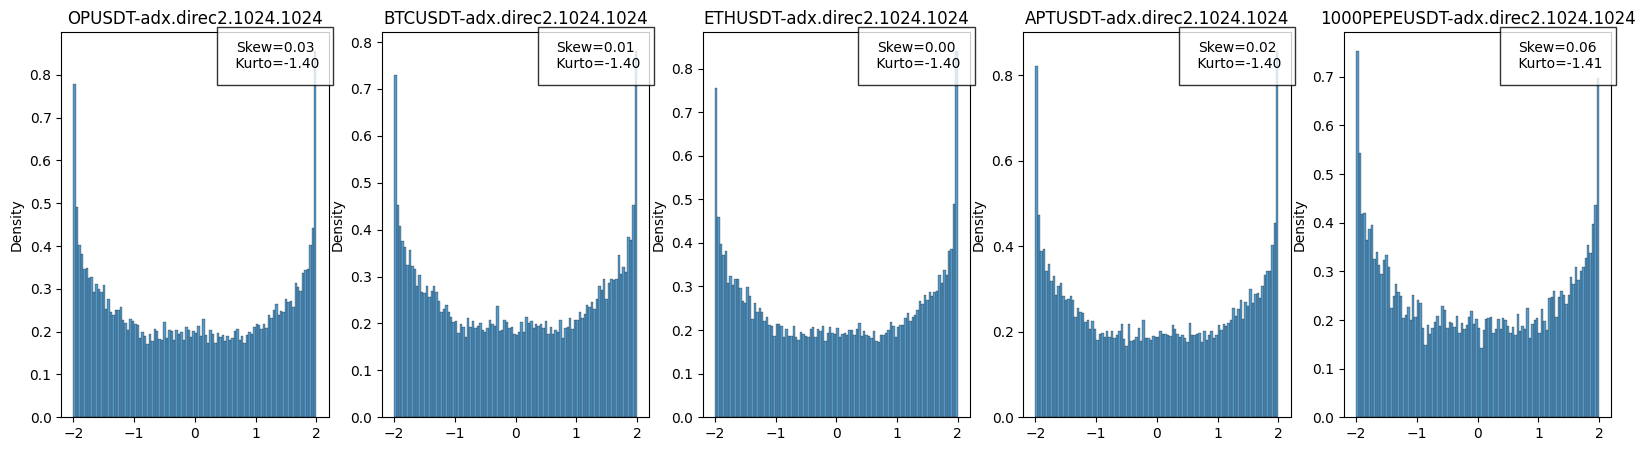

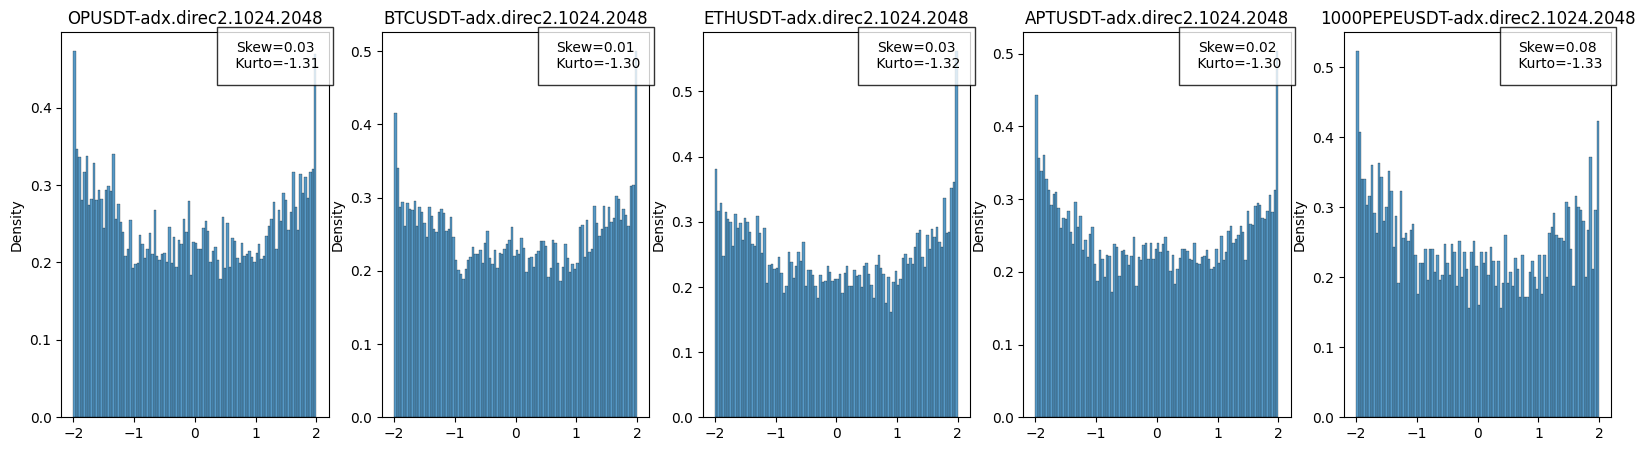

In [ ]:
for period in periods:
    f, axes = plt.subplots(1, len(product_list), figsize=(20, 5))
    signal_name = signal_name_format.format(period=period)
    for i, product in enumerate(product_list):
        arr = all_product_signal_periods[period][product]
        T = len(arr)
        arr = arr[np.arange(0, T, period)]
        skew = scipy.stats.skew(arr)
        kurto = scipy.stats.kurtosis(arr)
        summary_text = f"Skew={skew:.2f}\n Kurto={kurto:.2f}"
        # Plot the empirical histogram
        sns.histplot(arr, kde=False, bins=100, stat='density', label='Empirical', ax=axes[i])

        # # Fit a normal distribution to the data
        # mean, std = norm.fit(data)

        # # Generate values for the estimated normal distribution
        # x = np.linspace(min(data), max(data), 100)
        # y = norm.pdf(x, mean, std)

        # axes[i].plot(x, y, label='Estimated', color='red')
        axes[i].set_title(product + "-" + signal_name)
        axes[i].text(0.8, 0.9, summary_text, transform=axes[i].transAxes, ha='center', va='bottom',
                bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    f.show()

In [6]:
trades_signal_period = [signal_name_format.format(period=period) for period in periods]
results = factor_analysis.get_signal_performance_result(trades_signal_period, "signal_result_with_atr", product_list, 1e-4, 1)

trend_res = results['trend.signal.stat']
reve_res = results["reverse.signal.stat"]
signal_trend_res = trend_res[['signal', 'trainSharpe']].set_index('signal')['trainSharpe']
signal_rever_res = reve_res[['signal', 'trainSharpe']].set_index('signal')['trainSharpe']

trend_signals = signal_trend_res[(signal_trend_res - signal_rever_res) > 0].index
reverse_signals = signal_trend_res[(signal_trend_res - signal_rever_res) < 0].index
nouse_signals = signal_trend_res[(signal_trend_res - signal_rever_res) == 0].index

print("#trend={}, #reverse={}, #nouse={}".format(len(trend_signals), len(reverse_signals), len(nouse_signals)))

merge_res = pd.concat([trend_res.loc[np.isin(trend_res['signal'], trend_signals)], 
                       reve_res.loc[np.isin(reve_res['signal'], reverse_signals)]], 
                      axis=0)

display(merge_res.sort_values(by='trainSharpe', ascending=False))

no good product for adx.direc2.1024.32 trend
no good product for adx.direc2.1024.32 reverse
no good product for adx.direc2.1024.64 trend
no good product for adx.direc2.1024.64 reverse
no good product for adx.direc2.1024.128 trend
no good product for adx.direc2.1024.128 reverse
#trend=0, #reverse=4, #nouse=0


,signal,reverse,num_good_product,good_product,good_product_sharpe,trainSharpe,testSharpe,trainSharpeV2,testSharpeV2,trainAvgDailyTradeNum,testAvgDailyTradeNum,sum_good_strat,avgTrainRet,avgTestRet,trainReturn,testReturn
0,adx.direc2.1024.256,trend,4,"OPUSDT,ETHUSDT,APTUSDT,1000PEPEUSDT","0.99,1.45,1.84,2.28",1.639614,-0.114781,0.986947,-1.322000,26.163392,21.406088,49,0.004059,-0.000247,0.494852,-0.047362
3,adx.direc2.1024.2048,trend,3,"OPUSDT,APTUSDT,1000PEPEUSDT","0.69,0.63,2.7",1.340512,-0.211127,0.686253,0.547580,5.338526,4.638845,33,0.004712,-0.000269,0.392440,-0.061512
1,adx.direc2.1024.512,trend,4,"OPUSDT,ETHUSDT,APTUSDT,1000PEPEUSDT","0.78,0.93,1.76,1.88",1.335851,-0.058361,0.778362,-0.189111,18.881736,15.334333,63,0.004222,-0.000153,0.478101,-0.017469
2,adx.direc2.1024.1024,trend,5,"OPUSDT,BTCUSDT,ETHUSDT,APTUSDT,1000PEPEUSDT","0.83,0.26,1.07,0.96,2.71",1.166124,-0.468300,0.830776,-0.207282,11.765147,9.036178,56,0.003406,-0.000118,0.340399,-0.045040
